In [3]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
words = open('datasets/names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [6]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos) 

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [77]:
block_size = 3
X, Y = [], []
for w in words:
   # print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        #print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

In [186]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [11]:
C = torch.randn((27, 2))

In [21]:
F.one_hot(torch.tensor(5), num_classes = 27).float() @ C

tensor([ 2.8974, -0.8922])

In [19]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [26]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [37]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # setting it to -1 pytorch will infer the correct dimension, 
# as the number of elements has to stay the same

In [38]:
h.shape

torch.Size([32, 100])

In [39]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [43]:
logits = h @ W2 + b2

In [45]:
counts = logits.exp()

In [46]:
prob = counts / counts.sum(1, keepdims = True)

In [50]:
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(16.0211)

In [70]:
emb = C[X]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
#counts = logits.exp()
#prob = counts/counts.sum(1, keepdim = True)
#loss = -prob[torch.arange(32), Y].log().mean()
loss = F.cross_entropy(logits, Y) # exact same as above

In [ ]:
# --------- Here serious agiain

In [259]:
Xtr.shape, Ytr.shape # dataset

(torch.Size([182625, 3]), torch.Size([182625]))

In [260]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [261]:
sum(p.nelement() for p in parameters)

11897

In [262]:
for p in parameters:
    p.requires_grad = True

In [263]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
#plt.plot(lrs)

In [264]:
lri = []
lossi = []
stepi = []

In [265]:
for i in range(200000):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))
    
    # forward pass 
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix]) 
   # print(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    #update
  #  lr = lrs[i]
    lr = 0.1 if i<100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    #lri.append(lre[i])
    lossi.append(loss.log10().item())
    stepi.append(i)

print(loss.item())

2.2658700942993164


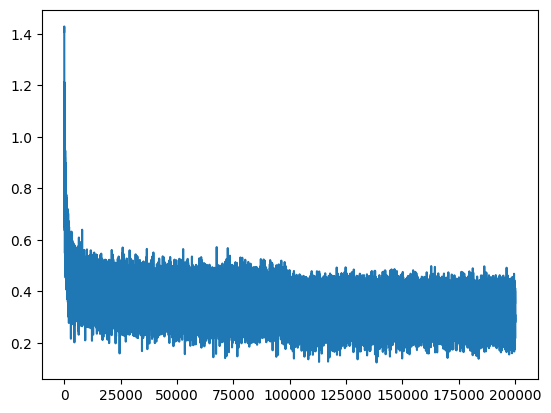

In [266]:
plt.plot(stepi,lossi)

In [267]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr) # exact same as above
loss

tensor(2.1285, grad_fn=<NllLossBackward0>)

In [268]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev) # exact same as above
loss

tensor(2.1693, grad_fn=<NllLossBackward0>)

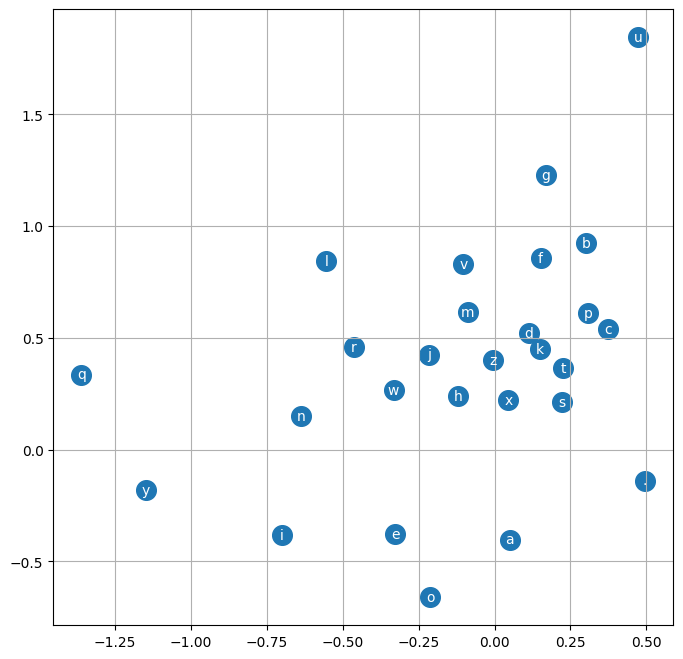

In [227]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [269]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

carlan.
amb.
harlin.
mili.
taty.
salaysa.
jazonte.
den.
rhe.
areen.
nellara.
chaiir.
kaleigh.
ham.
join.
quint.
shoine.
liven.
corte.
madiarynix.


In [271]:
A = C.view(-1,30)

In [273]:
C.shape

torch.Size([27, 10])

In [275]:
import pandas

In [278]:
import torch
import numpy as np
import pandas as pd



t_np = C.detach().numpy() #convert to Numpy array
df = pd.DataFrame(t_np) #convert to a dataframe
df.to_csv("testfile",index=False) #save to file

#Then, to reload:
df = pd.read_csv("testfile")

In [279]:
C

tensor([[ 2.0408e+00,  6.7124e-01, -1.0497e-02, -1.0429e+00,  7.4435e-01,
         -4.0441e-01, -2.2493e+00,  7.3794e-01,  4.0223e-01,  1.6177e+00],
        [-1.4915e-01,  5.2183e-01, -9.9813e-01, -1.0688e+00,  1.9655e+00,
          3.1705e+00,  1.9898e+00, -1.4007e+00,  6.2126e-01, -5.0289e-01],
        [ 9.4603e-01, -1.7851e-01, -1.5063e+00,  4.0225e-01, -1.2063e-01,
          1.4324e+00,  1.7713e+00, -1.1889e-01, -1.0007e+00,  1.5586e-01],
        [-1.4719e-02,  8.5235e-02, -1.4974e-01,  4.3933e-01, -7.4937e-01,
          4.3799e-01, -3.3440e-01,  4.8855e-01, -5.4835e-01, -1.4120e-01],
        [-3.9001e-02, -2.0625e-02, -5.9044e-01,  2.4824e-01, -4.6598e-01,
          8.8248e-01,  3.5392e-01,  3.1880e-01, -4.5097e-01, -3.3572e-01],
        [-8.5425e-01,  6.2895e-01,  1.2741e-01, -6.5626e-01, -1.9352e-01,
          5.0031e-01,  2.8414e-01, -4.4399e-01, -5.2042e-01, -4.1074e-01],
        [ 4.9045e-01, -7.3222e-01, -2.2256e+00, -9.0176e-01,  8.2234e-01,
         -6.3492e-01,  1.9106e+0